# M2608.001300 Machine Learning<br> Assignment #3 Training Convolutional Neural Networks (Pytorch)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jooyoung Choi, February 2020

**For understanding of this work, please carefully look at given PPT file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.


### Some helpful tutorials and references for assignment #3:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(36, 274, 3)


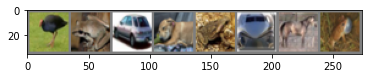

 bird  frog   car   dog
torch.Size([3, 32, 32])


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 100 output units and ReLU activation
* Fully connected layer with 80 output units and ReLU activation
* Fully connected layer with 10 output units and linear activation
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 8
* Training epoch: 2

In [0]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        conv1=nn.Conv2d(3,8,7,1) # 8@26*26
        pool=nn.MaxPool2d(2,stride=2) # 8@13*13
        conv2=nn.Conv2d(8,16,4,1) # 16@10*10
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool,
            conv2,
            nn.ReLU(),
            pool
        )

        fc1=nn.Linear(16*5*5,100)
        fc2=nn.Linear(100,80)
        fc3=nn.Linear(80,10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = self.conv_module(x) # @16*5*5
        
        dim = 1
        for d in x.size()[1:]: #16, 5, 5
            dim = dim * d
        x = x.view(-1, dim)
        x = self.fc_module(x)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x


In [0]:
# Function to train the network

def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [8]:
PATH = './cifar_net.pth'
epoch = 2

# initialize model
net = Net()

# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(net, trainloader, epoch, criterion, optimizer, PATH)

[1,  2000] loss: 2.167
[1,  4000] loss: 1.801
[1,  6000] loss: 1.589
[2,  2000] loss: 1.477
[2,  4000] loss: 1.403
[2,  6000] loss: 1.356
Finished Training
Saved Trained Model


In [0]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [10]:
# load trained model then test
net.load_state_dict(torch.load(PATH))
print_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 49 %


## 3. Design a better model on CIFAR-10
Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the test set</font>** of CIFAR-10. <br> You can use the implemented *inception class* below.

### Things you can try to change:
- Batch size (input parameter of dataloader)
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation

In [0]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [0]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        self.layer1=nn.Sequential(
            nn.Conv2d(3,192,kernel_size=3,padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.layer2=nn.Sequential(
           Inception(192,  64,  96, 128, 16, 32, 32),
           Inception(256, 128, 128, 192, 32, 96, 64),
           nn.MaxPool2d(3, stride=2, padding=1),
        )

        self.layer3=nn.Sequential(
           Inception(480, 192,  96, 208, 16,  48,  64),
           Inception(512, 160, 112, 224, 24,  64,  64),
           Inception(512, 128, 128, 256, 24,  64,  64),
           Inception(512, 112, 144, 288, 32,  64,  64),
           Inception(528, 256, 160, 320, 32, 128, 128),
           nn.MaxPool2d(3, stride=2, padding=1),
        )

        self.layer4=nn.Sequential(
            Inception(832, 256, 160, 320, 32, 128, 128),
            Inception(832, 384, 192, 384, 48, 128, 128),
            nn.AvgPool2d(8, stride=1),
        )
        
        self.fc=nn.Linear(1024, 12)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)

        size=out.size(0)
        out=out.view(size,-1)
        out=self.fc(out)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out


In [13]:
# initialize model
betternet = BetterNet()
betternet = betternet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(betternet.parameters(), lr=0.001, momentum=0.9)

PATH = './better_net.pth'
# Train
train(betternet, trainloader, 3, criterion, optimizer, PATH)
# Test
betternet.load_state_dict(torch.load(PATH))
print_accuracy(betternet, testloader)

[1,  2000] loss: 1.593
[1,  4000] loss: 1.168
[1,  6000] loss: 0.955
[2,  2000] loss: 0.791
[2,  4000] loss: 0.719
[2,  6000] loss: 0.657
[3,  2000] loss: 0.547
[3,  4000] loss: 0.544
[3,  6000] loss: 0.521
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 81 %


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

_Tell us here_

1 번째 시도: conv 후 pooling --> inception --> fully-connected layer : 49% accuracy

2번째 시도: 한개의 conv&incept layer 추가
즉, conv&pooling -->inception -->conv2&pooling-->inception2-->F.C. layer : 48% accuracy

3번째 시도: 2와 동일하게 하되 kernel size를 5에서 3으로 줄여봄 : 32% 

4번째 시도: 구조를 바꿔 google net처럼 conv&pooling 2번 반복 후 inception 2번 -->F.C : 46%

5번째 시도: pooling이 많아 데이터가 부족하다고 판단해 첫번째 pool없애고 재시도 : 50%

6th : 학습수가 부족하다고 생각해 epoch를 10으로 늘림 : 55%
7th : 시간이 많이 걸려 epoch를 5로 줄이고, inception을 초반에 하면 의미가 없을 것 같아 초반에 conv를 먼저 몇 번 하고 inception구조 여러번 추가 : 52%

8th: 같은 구조로 하면 아무리 바꾸어도 55퍼를 넘지않아 Inception구조를 googlenet과 같이 많이 써야함을 느껴 layer추가 및 마지막에 pooling시 전체 값을 사용하기 위해 max대신 avg를 사용함, 시간 많이 걸려서 epoch 3으로 줄임 : 63%

9th: fc에 input이 25600이고 output이 8 이라 근사가 너무 되었다고 판단하여 avgpool의 kernel_size를 4에서 6으로 늘려 fc(9216,8)로 갭 줄임 : 64%

10th: 한 번 더 올려서 kernel_size를 6에서 8로 해서 fc(1024,8) :63%

11th: output크기가 작아서 확률이 낮은것으로 판단되어 8에서 12로 올림 : 81% 성공!
